In [ ]:
import sys
import os
import json
import time
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from nlp_utils.src.nlputils import utils
from nlp_utils.src.nlputils.components.axaserver import axaprocessor, axasplitter

c:\Users\Prashant\anaconda3\envs\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
###### Declare the variables #######

path_to_files_list = "C:/Users/Prashant/Desktop/work/audit/processing/df_files.json"

path_to_save_output_from_parsr = "C:/Users/Prashant/Desktop/work/audit/imagepdf_df/"


In [3]:
# read the files dataframe
df_pdf = pd.read_json(path_to_files_list)\
                    .query('ImagePDF.notna() & ImagePDF==False').reset_index(drop=True)
df_pdf['pdf_path'] = df_pdf.apply(lambda x: x['orig_filepath'] if x['filetype'] == 'pdf' 
                                  else x['converted_filepath'],axis=1)
df_pdf = df_pdf[df_pdf.pdf_path.notna()]\
                    .sort_values(by = 'page_count',ascending=True)\
                    .reset_index(drop=True)
print("normal pdf files to be processed:",len(df_pdf))

# keeping image pdf as separate dataframe
df_imagepdf = pd.read_json(path_to_files_list)\
                    .query('ImagePDF.notna() & ImagePDF==True').reset_index(drop=True)
df_imagepdf['pdf_path'] = df_imagepdf.apply(lambda x: 
                                x['orig_filepath'] if x['filetype'] == 'pdf' 
                                else x['converted_filepath'],axis=1)
df_imagepdf = df_imagepdf[df_imagepdf.pdf_path.notna()]\
                    .sort_values(by = 'page_count',ascending=True)\
                    .reset_index(drop=True)
print("image pdf files to be processed:",len(df_imagepdf))

normal pdf files to be processed: 31
image pdf files to be processed: 113


## Document Processing

In [ ]:
files_to_process = df_imagepdf.pdf_path.tolist()

# batch size
batch_size = 10

# wait time
sleep_time = 120


# server config
config = "default"

# authfile for access token and url in HF
authfile = r"auht file which contains the urla nd auth token for docker running on hf"

# output saving location
path_to_save_output_from_parsr = "local folder to save the output from axaserver"

In [ ]:
batch = axaprocessor.axaBatchProcessingHF(authfile=authfile,config=config, batch_files=files_to_process)
batch.set_batch_params(batch_size=batch_size, batch_wait_time=sleep_time)
df_processed = batch.processing(path_to_save_output_from_parsr)

### Files Consolidation

In [ ]:
df_orig_files = pd.read_json(path_to_files_list)
print("total files:",len(df_orig_files))
processed_files = utils.get_files("location whre all btach files containing metadata information are saved",file_extensions=['json'])
tmp = pd.concat([pd.read_json(f) for f in processed_files['json']],ignore_index=True)
tmp['simple_json_download_successful'] = tmp.progress_apply(lambda x: os.path.isfile(x['path_to_docs'] 
            + os.path.splitext(x['filename'])[0] + '.simple.json') if x['path_to_docs'] else False,axis=1)
df_processed = tmp[(tmp.path_to_docs.notna()) & 
            (tmp.simple_json_download_successful == True)].reset_index(drop=True)
print("total files processed:",len(df_processed))
not_procesed = tmp[(tmp.path_to_docs.isna()) | (tmp.simple_json_download_successful == False)]

In [41]:
df_orig_files['file_path'] = df_orig_files.orig_filepath
not_procesed = pd.merge(not_procesed,df_orig_files, how='inner', on=['file_path'])
not_procesed

,file_path,filename,config,status_code,server_response,status,path_to_docs,simple_json_download_successful,filetype,orig_filepath,ImagePDF,page_count
0,../Data_A/Audit_Reports\Hospitals\Soroti Regio...,Soroti Regional Referral Hospital Report of th...,c:\Users\Prashant\OneDrive - Deutsche Gesellsc...,202,7e73c4617885b549b32ea1784c3825,201,None,False,pdf,../Data_A/Audit_Reports\Hospitals\Soroti Regio...,False,37


## Chunking

In [17]:
def create_save_chunks(filename,path_to_docs):
    # create chunks
    chunks = axasplitter.simplejson_splitter(
            json_filepath=path_to_docs + os.path.splitext(filename)[0]+'.simple.json',
            filename = os.path.splitext(filename)[0],page_start=0,
            headings_level=2,lower_threshold=50, upper_threshold=50)
    # save chunks
    with open(path_to_docs+os.path.splitext(filename)[0]+'.chunks.json', 'w') as file:
        json.dump(chunks, file)
    # return chunks filepath
    return path_to_docs+ os.path.splitext(filename)[0] +'.chunks.json'

In [18]:
df_processed['chunks_filepath'] = df_processed.progress_apply(lambda x: 
                                    create_save_chunks(x['filename'],x['path_to_docs']) 
                                    if x['simple_json_download_successful'] else None,axis=1)

100%|██████████| 143/143 [00:20<00:00,  6.99it/s]


In [19]:
import json
jsonfile = df_processed.to_json(orient="records")
parsed = json.loads(jsonfile)
with open("C:/Users/Prashant/Desktop/work/audit/processing/processed_chunks.json", 'w') as file:
    json.dump(parsed, file, indent=4)

# Quality check

We will perform a brief quality check on the quality of data, both at page level and then at chunks level

In [20]:
# read the chunks metadata file
df = pd.read_json("C:/Users/Prashant/Desktop/work/audit/processing/processed_chunks.json")
df = df[df.simple_json_download_successful ==True].reset_index(drop=True)

In [21]:
# Performing page level checks

# read raw text page wise using axaprocessor
df['pages'] = df.progress_apply(lambda x: axaprocessor.get_pagewise_text(x['path_to_docs'] + 
                                os.path.splitext(x['filename'])[0]+'.simple.json'),axis=1)

# check for text quality page wise
def check_pages(pages):
    page_check= []
    for page in pages:
        # using gibberish function to detect quality
        page_check.append(utils.is_gibberish(page['content']))
    return page_check

df['gibberish_page_check'] = df.pages.progress_apply(lambda x: check_pages(x))
df['extracted_page_count'] = df.gibberish_page_check.apply(lambda x: len(x))
df = df[df.extracted_page_count != 0].reset_index(drop=True)

df['gibberish_doc_percent'] = df.gibberish_page_check.progress_apply(lambda x: round((sum(x)/len(x)),2))
# checking files percent based on percentage of pages good
# usually from the experience its seen its a good benchmark
# reason for .35 thres is from fact that if document is only 3 pages and of these 1 page is not good 
# its better to check.
print("Total Number of okay files:", len(df[df.gibberish_doc_percent <= 0.35]))

100%|██████████| 143/143 [00:00<00:00, 95083.30it/s]

Total Number of okay files: 142


Total docs having atleast 1 page classified as gibberish: 17


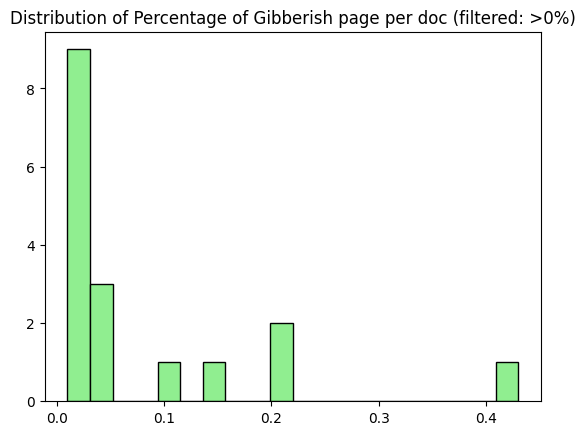

In [22]:
import matplotlib.pyplot as plt

# plot to see the distribution of documents which have atleast one page being classified as gibberish
df['gibberish_page_count'] = df.gibberish_page_check.apply(lambda x: sum(x))
print("Total docs having atleast 1 page classified as gibberish:", 
                        len(df.query('gibberish_doc_percent > 0')))
plt.hist(df.query('gibberish_doc_percent > 0').gibberish_doc_percent, color='lightgreen', 
                                                                ec='black', bins=20)
plt.title("Distribution of Percentage of Gibberish page per doc (filtered: >0%)")
plt.show()

Perform some random check on the documents to asses the quality too

In [ ]:
# # this code block can be sued o filter soem documents which can be used for spot check
# # reason for .35 thres is from fact that if document is only 3 pages and of these 1 page is not good 
# # its better to check.

# #### uncomment below and use #########
# to_be_checked = df.query('gibberish_doc_percent > 0')\
#                             .query('gibberish_doc_percent <=0.35')\
#                             .reset_index()

# to_be_checked['checklist'] = to_be_checked.gibberish_page_check.apply(lambda x: [
#                                                         i for i,j in enumerate(x) if j])

# # drop where its only first page
# to_be_checked['check'] = to_be_checked.checklist.apply(lambda x: False if (len(x) ==1) and (x[0]==0) else True)
# to_be_checked = to_be_checked[to_be_checked.check==True].drop(columns=['gibberish_page_check',
#                                                         'check']).reset_index(drop=True)
# to_be_checked.to_csv('manual_check.csv', index=False)
# to_be_checked

In [ ]:
# performing the same quality check on paragraph/chunks level
def check_chunks(filepath):
    with open(filepath) as file:
        chunks  =  json.load(file)
    
    chunks = chunks['paragraphs']
    if len(chunks)!= 0:
        chunks = pd.DataFrame(chunks)
        chunks['check'] = chunks.content.apply(lambda x: utils.is_gibberish(str(x)))
    return list(chunks.check)

df['gibberish_chunk_check'] = df.chunks_filepath.progress_apply(lambda x: check_chunks(x))
df['chunks_count'] = df.gibberish_chunk_check.apply(lambda x: len(x))
df['gibberish_chunks_percent'] = df.gibberish_chunk_check.apply(lambda x: round((sum(x)/len(x)),2))
df['gibberish_chunks_count'] = df.gibberish_chunk_check.apply(lambda x: sum(x))

100%|██████████| 648/648 [00:16<00:00, 39.39it/s]


Total docs having atleast 5 percentage of  chunk classified as gibberish: 159


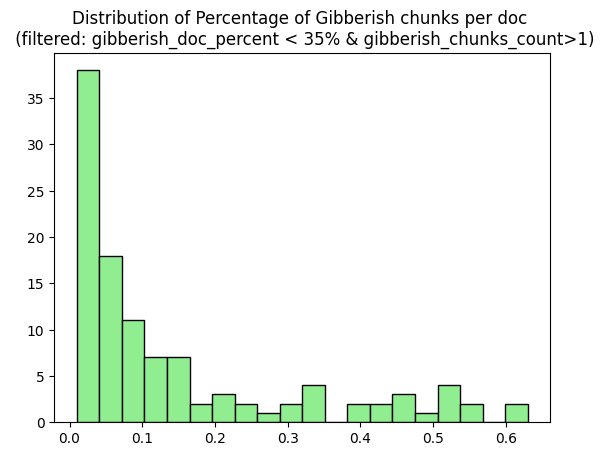

In [ ]:
import matplotlib.pyplot as plt

# plot to see the % distribution ofgibberish chunks documents which have more than 35% page classifed as gibberish

print("Total docs having atleast 5 percentage of  chunk classified as gibberish:", 
                                    len(df.query('gibberish_chunks_percent > 0.05')))
plt.hist(df.query('gibberish_doc_percent < 0.35').query('gibberish_chunks_count >1')\
                .gibberish_chunks_percent, color='lightgreen', ec='black', bins=20)
plt.title("""Distribution of Percentage of Gibberish chunks per doc \n 
          (filtered: gibberish_doc_percent < 35% & gibberish_chunks_count>1)""")
plt.show()